In [1]:
%load_ext autoreload
%autoreload
from fedhybrid_innerloops import FedHybrid
from tune_and_draw import TuneAndDraw
from parameter import TuneParam,TrainParam
from costFunc import QuadraticCostFunc
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import random

from sklearn.datasets import load_boston
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

import json
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import minimize

In [3]:
def dataset(nclient):
    np.random.seed(2022)
    random.seed(2022)
    boston_dataset = load_boston()
    boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
    boston['MEDV'] = boston_dataset.target
    X = boston.drop('MEDV', axis = 1) #Drop columns
    y = boston['MEDV']  
    scaler = preprocessing.StandardScaler()
    X = scaler.fit_transform(X)#x-mean/std(Standard deviation)
    X = pd.DataFrame(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 5)#Pass an int for reproducible output across multiple function calls.
    # Not uniformly distributed among clients
    X_train, y_train = shuffle(X_train, y_train)
    #for python array we do not need to use copy function but for numpy array, we need to use copy function
    X_df = X_train.copy()
    X_df['y_train'] = y_train
    
    X_df = X_df.reset_index(drop=True)

    X_df_sorted = X_df.sort_values(by = ['y_train'])
    
    X_df_sorted = X_df_sorted.reset_index()
    #print(X_df_sorted.head(5))# save original index and add new index
    X_train = X_df.drop('y_train', axis = 1)
    y_train = X_df['y_train']
    n = len(y_train)
    print('n',n)
    ndim = X_train.shape[1] + 1  # to add vector of all ones
    print(ndim)
    # number of samples 
    #Compared to the original X_train, it has a new index. start from 0 
    #print('X_train.shape[1])',X_train.shape[1])
    #print('1: ',X_train.head(5))
    intercept = np.ones((X_train.shape[0], 1))
    #print(intercept)
    X_train = np.hstack((intercept, X_train)) #Stack arrays in sequence horizontally (column wise).
    #print('2: ',X_train[0])
    intercept = np.ones((X_test.shape[0], 1))
    X_test = np.hstack((intercept, X_test))
    # number of samples at each client
    p = np.zeros(nclient)
    s = 0
    for i in range(nclient):
        p[i] = random.uniform(0.1, 1)
        s += p[i]
    p = p/s
    ni = p.copy() * n #n=len(y_train)
    ni = [int(num) for num in ni]
    ni[-1] = ni[-1] + n - sum(ni)
    #print(ni)
    indices_set = [[] for i in range(nclient)]
    s = 0
    for j in range(nclient):
        indices_set[j] =  X_df_sorted['index'].to_list()[s:s+ni[j]]
        s += ni[j]
    A = [[] for _ in range(nclient)]
    y = [[] for _ in range(nclient)]
    condiNum = np.zeros(nclient)
    for i in range(nclient):
        A[i] = X_train[indices_set[i]]
        y[i] = y_train[indices_set[i]]
        y[i]=y[i].to_numpy()

    return A,y

In [4]:
A,y = dataset(8)
condNum= np.zeros(8)
for i in range(8):
    eigenvalue =np.linalg.eigh(np.transpose(A[i]).dot(A[i]))[0]
    condNum[i] = np.sqrt(eigenvalue[-1]/eigenvalue[0])
    if np.isnan(condNum[i]):
        condNum[i] = np.inf
print(condNum)

n 354
14
[2.23415551e+08 2.98680538e+01 2.11486504e+01            inf
 1.31397651e+01 3.00844398e+01 6.47375323e+01 6.46066537e+01]


c:\Users\zzm7360\.conda\envs\cs349hw2\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housi

In [5]:

def prepare(nclient):
    A,y= dataset(nclient)
    ndim = len(A[0][0])
    func = QuadraticCostFunc(A, y, gamma=1) #cost function 
    initial_x =  np.zeros([ndim,1])
    fn_min = minimize(func.global_func, initial_x, tol=1e-30) #result object
    fn_star = fn_min.fun 
    tuneAndDraw = TuneAndDraw(nclient, initial_x,setup=2)
    method = FedHybrid(func, fn_star)
    return method,tuneAndDraw

synchronous:

c:\Users\zzm7360\.conda\envs\cs349hw2\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housi

n 354
14
data int64
2.043435642917757e-09 121 1
1.9267076822870877e-09 80 1
1.7841443877841812e-09 77 1
1.7791990103432909e-09 63 1
1.1618510598054854e-09 22 1


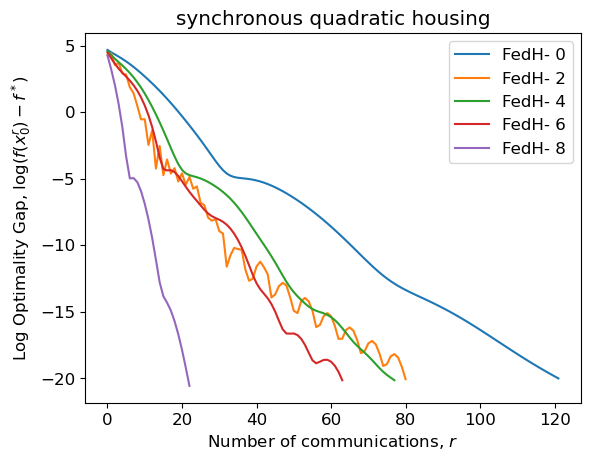

In [25]:
method,tuneAndDraw = prepare(8)
ns=[0,2,4,6,8]
innerIterations = 1
df = tuneAndDraw.readPa(ns,innerIterations)
filename="./analyze data/analyze data/sync_and_async/synchronous quadratic housing.pdf"
tuneAndDraw.draw(df,method.train_innerloop,"synchronous quadratic housing",filename,save = 0,asyn=0,possionBeta=[])

async

c:\Users\zzm7360\.conda\envs\cs349hw2\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housi

n 354
14
data int64
1.9482797597447643e-09 6928 1
2.058982317976188e-09 6967 1
2.0573338588292245e-09 6968 1
1.7400623164576245e-09 6139 1
1.734179022605531e-09 6139 1


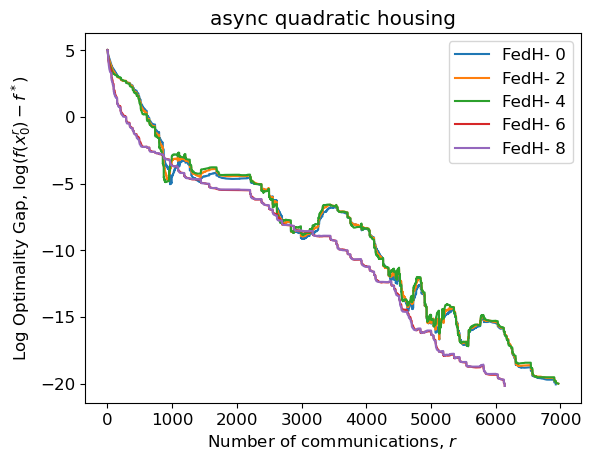

In [24]:

method,tuneAndDraw = prepare(8)
ns=[0,2,4,6,8]
innerIterations = 0
df = tuneAndDraw.readPa(ns,innerIterations)
filename="./analyze data/analyze data/sync_and_async/2 asynchronous quadratic housing3.pdf"
tuneAndDraw.draw(df,method.asynchronousTrain2,"async quadratic housing",filename,save=1,asyn=1,possionBeta = [1,2,3,1,20,25,4,1])

c:\Users\zzm7360\.conda\envs\cs349hw2\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housi

n 354
14
data int64
1.493020818088553e-09 9601 1
1.115665781981079e-09 9601 1
1.4831869066256331e-09 9601 1
1.2379643976601074e-09 9601 1
1.6264891655737301e-09 8146 1
1.6092656096589053e-09 8146 1
1.6119088286359329e-09 8146 1


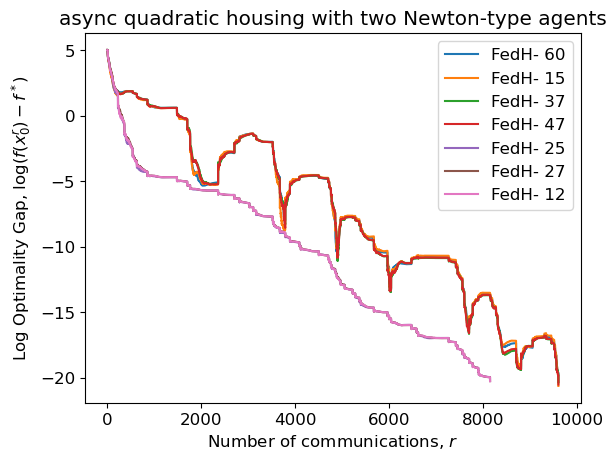

In [25]:
method,tuneAndDraw = prepare(8)
ns=[60,15,37,47,25,27,12]
innerIterations = -1
df = tuneAndDraw.readPa(ns,innerIterations)
filename="./analyze data/analyze data/sync_and_async/2 async quadratic housing with two Newton-type agents.pdf"
tuneAndDraw.draw(df,method.asynchronousTrain2,"async quadratic housing with two Newton-type agents",filename,save=1,asyn=1,possionBeta = [1,2,30,1,2,4,4,1])

innerloop

c:\Users\zzm7360\.conda\envs\cs349hw2\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housi

n 354
14
data int64
1.726164100546157e-09 56 1
1.6090666576928925e-09 47 1
1.987785935853026e-09 44 1
1.4656222901976435e-09 46 1
1.1618510598054854e-09 22 1


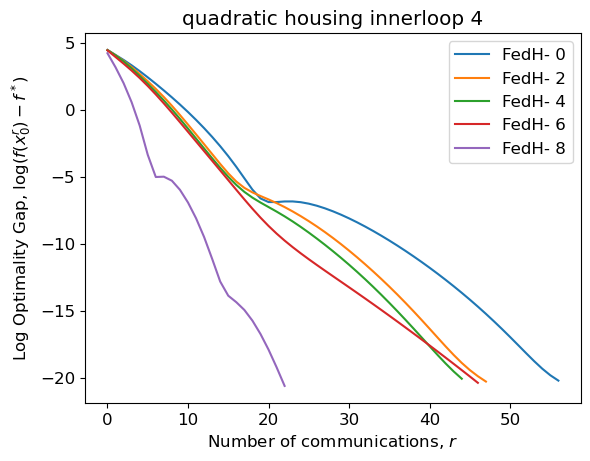

In [26]:
method,tuneAndDraw = prepare(8)
ns=[0,2,4,6,8]
innerIterations =4
df = tuneAndDraw.readPa(ns,innerIterations)
filename="./analyze data/analyze data/sync_and_async/2 innerloop 4 quadratic housing before2.pdf"
tuneAndDraw.draw(df,method.train_innerloop_lambdaBefore,"quadratic housing innerloop 4",filename,save = 1,asyn=0,possionBeta=[])

In [ ]:
method,tuneAndDraw = prepare(8)
#param = tuneAndDraw.direct_train(alpha1=0,beta1=0,alpha2=0,beta2=-6,mu=5,K=10000,client_Newton=[0,1,2,3,4,5,6,7,8,9])

#param = tuneAndDraw.direct_train(alpha1=-14,beta1=3,alpha2=0,beta2=0,mu=6,K=50000,client_Newton=[])
#param = tuneAndDraw.direct_train(alpha1=-12,beta1=5,alpha2=0,beta2=-6,mu=6,K=30000,client_Newton=[4,6])
param = tuneAndDraw.direct_train(alpha1=-12,beta1=5,alpha2=0,beta2=-6,mu=6,K=30000,client_Newton=[6, 1, 9, 2, 3, 8])
#param = tuneAndDraw.direct_train(alpha1=-10,beta1=4,alpha2=0,beta2=-6,mu=5,K=30000,client_Newton=[0, 9, 3, 5, 7, 6, 8, 2])
fn_list, k_iter, _,success = method.train_innerloop_gradient_only_quadratic(param,3)
print(fn_list[-1],k_iter,success)

plt.plot(np.log(fn_list),label='FedH- %s' % '10')
plt.legend()
plt.title('innerloops'+str(1)+' logistic synthetic')
plt.rcParams.update({'font.size': 12})
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.xlabel('Number of communications, '  + r'$r$')
plt.ylabel('Log Optimality Gap, ' + r'$\log(f(x_0^r) - f^*)$')
plt.show()

In [5]:

nodes = [40,50]
for nclient in nodes:
    method,tuneAndDraw = prepare(nclient)
    if nclient ==30:
        ns=[0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30]
    elif nclient == 40:
        ns =[0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40]
    elif nclient ==50:
        ns =[0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
    
    inner=[1,2,3,4,5,6,7,8,9,10,11,12]
    setup=2   
    #Best_pa_after_new = tuneAndDraw.tune(method,ns,inner,method.train_innerloop_lambdaAfter,'afterNew')
    #Best_pa_after_new.to_csv('./setup_'+str(setup)+'_result/nodes2/'+'tune_result'+'_'+date_time+'_'+'node_'+str(nclient)+'_afterNew'+'.csv',index=False)
    #Best_pa_inner = tuneAndDraw.tune(method,ns,inner,method.train_innerloop,'inner')
    #Best_pa_inner.to_csv('./setup_'+str(setup)+'_result/nodes2/'+'tune_result'+'_'+date_time+'_'+'node_'+str(nclient)+'_inner'+'.csv',index=False)
    Best_pa_gra = tuneAndDraw.tune(method,ns,inner,method.train_innerloop_gradient_only,'gradient')
    now = datetime.now() # current date and time
    date_time = now.strftime("%m_%d_%Y, %H_%M")# month date year
    Best_pa_gra.to_csv('./setup_'+str(setup)+'_result/nodes3_all_optimal_stepsizes/'+'tune_result'+'_'+date_time+'_'+'node_'+str(nclient)+'_gradient'+'.csv',index=False)
    
    #Best_pa_bef = tuneAndDraw.tune(method,ns,inner,method.train_innerloop_lambdaBefore,'before')
    
 
    #Best_pa_after_new.to_csv('./setup_'+str(setup)+'_result/nodes/'+'tune_result'+'_'+date_time+'_'+'node_'+str(nclient)+'_afterNew'+'.csv',index=False)
    #Best_pa_inner.to_csv('./setup_'+str(setup)+'_result/nodes/'+'tune_result'+'_'+date_time+'_'+'node_'+str(nclient)+'_inner'+'.csv',index=False)
    #Best_pa_gra.to_csv('./setup_'+str(setup)+'_result/nodes/'+'tune_result'+'_'+date_time+'_'+'node_'+str(nclient)+'_gradient'+'.csv',index=False)
    #Best_pa_bef.to_csv('./setup_'+str(setup)+'_result/nodes2/'+'tune_result'+'_'+date_time+'_'+'node_'+str(nclient)+'_before'+'.csv',index=False)



/home/zzm7360/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing 

n 354
14
[9, 8, 6, 2, 13, 16, 7, 11, 13, 14, 13, 6, 11, 9, 9, 2, 12, 5, 15, 14, 7, 7, 2, 7, 8, 1, 5, 8, 2, 3, 3, 7, 16, 5, 2, 16, 11, 8, 5, 36]
40
40   0 :  [4, 3, 2, 1, 0, -1, -2] [0, -1, -2, -3, -4, -5, -6, -7] [0] [0] [-6, -5, -4, -3, -2, -1, 0] 500 []
client_gradient [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
client_newton []
<bound method FedHybrid.train_innerloop_gradient_only of <fedhybrid_innerloops.FedHybrid object at 0x7efeff173f40>> nclient 40
a_range [4, 3, 2, 1, 0, -1, -2] b_range [0, -1, -2, -3, -4, -5, -6, -7] a2_range [0] b2_range [0] mu_range [-6, -5, -4, -3, -2, -1, 0] newton_client []
40
40   2 :  [4, 3, 2, 1, 0, -1, -2] [0, -1, -2, -3, -4, -5, -6, -7] [0] [0, -1, -2, -3, -4, -5, -6] [-6, -5, -4, -3, -2, -1, 0] 500 [16 39]
client_gradient [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
client_newton [16 39]
<bound method

/home/zzm7360/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing 

n 354
14
[7, 6, 5, 2, 11, 13, 6, 9, 11, 12, 10, 5, 9, 8, 7, 1, 10, 4, 12, 12, 5, 6, 2, 6, 6, 1, 4, 7, 2, 2, 2, 6, 13, 4, 1, 13, 9, 6, 4, 13, 6, 1, 10, 6, 9, 10, 5, 6, 2, 27]
50
50   0 :  [4, 3, 2, 1, 0, -1, -2] [0, -1, -2, -3, -4, -5, -6, -7] [0] [0] [-6, -5, -4, -3, -2, -1, 0] 500 []
client_gradient [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
client_newton []
<bound method FedHybrid.train_innerloop_gradient_only of <fedhybrid_innerloops.FedHybrid object at 0x7efefe92b1f0>> nclient 50
a_range [4, 3, 2, 1, 0, -1, -2] b_range [0, -1, -2, -3, -4, -5, -6, -7] a2_range [0] b2_range [0] mu_range [-6, -5, -4, -3, -2, -1, 0] newton_client []
50
50   2 :  [4, 3, 2, 1, 0, -1, -2] [0, -1, -2, -3, -4, -5, -6, -7] [0] [0, -1, -2, -3, -4, -5, -6] [-6, -5, -4, -3, -2, -1, 0] 500 [16 39]
client_gradient [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24
 25 26 27 28 29 30

In [6]:
gamma = 1
func = QuadraticCostFunc(A, y, gamma) #cost function 
initial_x =  np.zeros([ndim,1])
fn_min = minimize(func.global_func, initial_x, tol=1e-30) #result object
fn_star = fn_min.fun 
tuneAndDraw = TuneAndDraw(nclient, initial_x,setup=2)

NameError: name 'ndim' is not defined

In [ ]:
method = FedHybrid(func, fn_star)
ns=[0,2,4,6,8]
innerIterations = 3
tuneAndDraw.draw(ns,innerIterations,method.train_innerloop_gradient_only)

In [ ]:
method = FedHybrid(func, fn_star)
ns=[0,2,4,6,8]
inner=[1,2,3,4,5,6,7,8]
#tuneAndDraw.tune(method,ns,inner,method.train_innerloop,'train_innerloop')
#tuneAndDraw.tune(method,ns,inner,method.train_innerloop_gradient_only,'gradient_only')
#tuneAndDraw.tune(method,ns,inner,method.train_innerloop_lambdaBefore,'before')
BestPa_after_new = tuneAndDraw.tune(method,ns,inner,method.train_innerloop_lambdaAfter)


In [ ]:
name = 'after_new'
now = datetime.now() # current date and time
date_time = now.strftime("%m_%d_%Y, %H_%M")# month date year
BestPa_after_new.to_csv('./setup_'+str(2)+'_result/largeScale/'+'tune_result'+'_'+date_time+'_'+name+'.csv',index=False)